In [1]:
#!conda env export -n pyscenic > environment.yml

In [2]:
import scanpy as sc
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
import pickle
import pyscenic
from pyscenic.rss import regulon_specificity_scores

In [3]:
sc.logging.print_header()

/home/jovyan/my-conda-envs/pyscenic/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


scanpy==1.9.3 anndata==0.8.0 umap==0.5.3 numpy==1.23.5 scipy==1.10.1 pandas==1.5.3 scikit-learn==1.2.2 statsmodels==0.13.5 python-igraph==0.10.3 pynndescent==0.5.8


# Goal
Make stable regulons (found in at least 80% or runs, genes present in the regulon at least in 80% of cases when the regulon was found)
# Input data:
1. fskOrg_All200c_hm.h5ad (celltype annotation only is used)
2. auc_mtx.csv.gz matrices (per cell regulon scores) produced by endo_scenic_all_run_ok_hm.ipynb
3. regulons.p with regulon content (list of regulated genes) produced by endo_scenic_all_run_ok_hm.ipynb

# Output
1. stable_regulons.pk - stable regulons (prev regulons_stable_80pct.csv)
2. stable_regulons_rss.pk - mean regulon-celltype weights (prev regulons_stable_80pct_rss.csv)

In [4]:
path='../../../data.nfs/from.stephane/20220120_GambardellaL_HM_mnsc/'

In [5]:
#subsetted <= 200 cells per type
a200c = sc.read_h5ad(path+'Data/Scenic/Hdf5/fskOrg_All200c_hm.h5ad')
a200c

AnnData object with n_obs × n_vars = 8429 × 25431
    obs: 'sanger_id', 'chemistry', 'batch', 'gender', 'pcw', 'sorting', 'sample', 'chemistry_sorting', 'cell_caller', 'scrublet_score', 'cluster_scrublet_score', 'doublet_pval', 'bh_doublet_pval', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'percent_hb', 'independent_annotation_refined', 'independent_annotation_broad1', 'independent_annotation_broad2', 'independent_annotation_broad3', 'independent_annotation_broad4', 'independent_annotation_broad5', 'joint_annotation', 'is_maternal', 'fig1b_annotation', 'independent_annotation_refined_20220201a', 'independent_annotation_refined_20220201b', 'independent_annotation_broad1_20220201', 'independent_annotation_broad2_20220201', 'independent_annotation_broad3_20220201', 'joint_annotation_20220201a', 'joint_annotation_20220201b', 'fig1b_annotation_20220201', 'joint_annotation_20220202', 'independent_annotation_refined_20220202', 'annot', 'day', 'sample_id', 'version', 'week', 'nh3_an

# Stable regulons
1. ound in at least 80% of runs
2. consist of genes found in at least 80% of the regulon instances

In [6]:
regs = [pickle.load(open("../../../data.nfs/from.stephane/20220120_GambardellaL_HM_mnsc/Data/Scenic/All200c"+str(i)+"/Output/regulons.p",'rb')) for i in range(0,10)]

In [7]:
from collections import defaultdict
import math
# number of runs where regulon was found
regcount = defaultdict(lambda:0)
# number of runs where gene was found for given regulon
reg2gens = defaultdict(lambda:defaultdict(lambda:0))
for rs in regs:
    for r in rs:
        regcount[r.name]+=1
        for g in r.gene2weight.keys():
            reg2gens[r.name][g] += 1

In [8]:
reg2gensf = {k:[g for (g,n) in v.items() if n >= math.floor(0.8*regcount[k])] for (k,v) in reg2gens.items() if regcount[k] >= 8}
reg2gensf = {k:v for (k,v) in reg2gensf.items() if len(v)>0}

In [9]:
len(reg2gensf)

371

In [10]:
with open('stable_regulons.pk', 'wb') as handle:
    pickle.dump(reg2gensf, handle)

In [11]:
regsnames = list(reg2gensf.keys())
regs = [','.join(reg2gensf[k]) for k in regsnames]
pd.DataFrame({'Regulon name': regsnames,'regulon genes': regs}).to_csv('stable_regulons.csv')

# Regulon score

In [12]:
# read cell-by-regulone scores (output of endo_scenic_all_run_ok_hm.ipynb)
aucs = [pd.read_csv(path+"/Data/Scenic/All200c"+str(i)+"/Output/auc_mtx.csv.gz",index_col='Cell') for i in range(0,10)]

In [13]:
rsss = [regulon_specificity_scores(auc,a200c.obs.annotToUse2) for auc in aucs]

In [14]:
# summ scores across runs
rss = rsss[0]
for r in rsss[1:]:
    rss = rss.add(r,fill_value=0)
rss.head()

,ACO1(+),AHCTF1(+),AHR(+),AHRR(+),ALX1(+),ALX3(+),ALX4(+),AR(+),ARID3A(+),ARID5B(+),...,ZNF844(+),ZNF846(+),ZNF878(+),ZNF91(+),ZNF93(+),ZSCAN22(+),ZSCAN29(+),ZSCAN31(+),ZSCAN9(+),ZXDA(+)
fetal_Adipocytes,0.839310,0.567467,0.189424,0.173260,1.794533,0.761726,1.999200,2.471024,1.889748,0.816423,...,0.259420,0.188296,0.818966,1.952147,0.398744,0.186173,0.171757,0.364743,0.539197,0.180214
organoid_Adipocytes,0.872941,0.588993,0.180017,0.191936,1.783791,0.932806,2.113207,2.772408,1.949629,0.822959,...,0.171442,0.182014,0.764202,2.019493,0.386772,0.174502,0.187376,0.354444,0.545273,0.226546
fetal_Basal,0.742475,0.564093,0.171514,0.170980,1.908215,0.702026,1.886573,1.768827,1.867260,0.795980,...,0.222104,0.183380,0.704352,1.951582,0.353386,0.171070,0.174271,0.348176,0.556421,0.183021
organoid_Basal,0.758778,0.615558,0.174909,0.177172,1.817523,0.863146,1.960331,2.051021,2.001929,0.808185,...,0.189832,0.175353,0.714508,2.081599,0.369715,0.173922,0.179633,0.375767,0.607753,0.201679
fetal_Capillary arterioles,0.743805,0.560310,0.190827,0.171109,1.857196,0.682389,1.777549,1.988984,1.905879,0.747729,...,0.188320,0.205158,0.765713,1.851727,0.367529,0.194251,0.196851,0.344815,0.538498,0.179438


In [15]:
# take mean across runs
regn = dict(Counter([i for r in rsss for i in list(r.columns)]))
rssn = rss.div(regn)

In [16]:
rssnf = rssn[list(reg2gensf.keys())].T
rssnf

,fetal_Adipocytes,organoid_Adipocytes,fetal_Basal,organoid_Basal,fetal_Capillary arterioles,organoid_Capillary arterioles,fetal_Companion layer,organoid_Companion layer,fetal_Cuticle/cortex,organoid_Cuticle/cortex,...,fetal_Periderm,organoid_Periderm,fetal_Pre-dermal condensate,organoid_Pre-dermal condensate,fetal_SPP1+ Neuron progenitors,organoid_SPP1+ Neuron progenitors,fetal_Schwann/Schwann precursors,organoid_Schwann/Schwann precursors,fetal_Suprabasal IFE,organoid_Suprabasal IFE
ALX1(+),0.179453,0.178379,0.190822,0.181752,0.185720,0.177817,0.171257,0.179816,0.170924,0.171995,...,0.175378,0.178224,0.189081,0.179678,0.202051,0.189092,0.203198,0.192063,0.171003,0.176839
ALX4(+),0.199920,0.211321,0.188657,0.196033,0.177755,0.175123,0.171381,0.186852,0.171335,0.201149,...,0.179579,0.184972,0.203081,0.222169,0.183000,0.192328,0.183435,0.188068,0.170934,0.183863
AR(+),0.247102,0.277241,0.176883,0.205102,0.198898,0.187579,0.169712,0.182003,0.168512,0.173966,...,0.177456,0.176931,0.215611,0.233147,0.178981,0.188433,0.200894,0.200050,0.168532,0.180484
ARID3A(+),0.188975,0.194963,0.186726,0.200193,0.190588,0.191901,0.174450,0.212589,0.171434,0.202723,...,0.210658,0.245488,0.192233,0.199438,0.183363,0.189317,0.183094,0.189091,0.177057,0.224221
ARNT2(+),0.201009,0.194660,0.185158,0.185497,0.187917,0.180801,0.171060,0.183540,0.170215,0.183701,...,0.192461,0.198544,0.198959,0.190675,0.214242,0.221827,0.230538,0.226964,0.171909,0.185787
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SMAD1(+),0.206644,0.199335,0.198269,0.195037,0.246676,0.217396,0.172809,0.190434,0.171754,0.184822,...,0.185267,0.188849,0.207384,0.202026,0.200458,0.200070,0.209626,0.201075,0.172623,0.189577
STAT5B(+),0.203524,0.233081,0.185603,0.197665,0.185867,0.172280,0.171703,0.192045,0.170502,0.182198,...,0.188902,0.181981,0.181116,0.199394,0.185656,0.184574,0.190672,0.180153,0.172415,0.193564
TEF(+),0.237568,0.191001,0.182758,0.194717,0.179432,0.173048,0.178801,0.217066,0.172538,0.203309,...,0.187299,0.206141,0.193659,0.188931,0.189110,0.186563,0.189277,0.186064,0.178032,0.244295
ZBTB14(+),0.192803,0.198124,0.195968,0.205020,0.187840,0.187002,0.172972,0.197718,0.170326,0.196977,...,0.184316,0.189205,0.190615,0.206862,0.188861,0.194217,0.190119,0.192569,0.173789,0.191205


In [17]:
with open('stable_regulons_rss.pk', 'wb') as handle:
    pickle.dump(rssnf, handle)

In [34]:
# save GATA2 regulon
pd.DataFrame(reg2gensf['GATA2(+)']).to_csv('regulons_stable_80pct_GATA2_stringDbQuery.csv')

# compare with Stephane's outputs
(they seems to be almost identicall)

In [18]:
with open('stable_regulons.pk', 'rb') as handle:
    r2g = pickle.load(handle)
with open('stable_regulons_rss.pk', 'rb') as handle:
    rss = pickle.load(handle)
rss.shape

(371, 54)

## RSS

In [19]:
path='../../../data.nfs/from.stephane/20220120_GambardellaL_HM_mnsc/'
st_rss = pd.read_csv(path+'/Data/Scenic/All200c/Output/regulons_stable_80pct_rss.csv',index_col=0).T
st_rss

index,fetal_Adipocytes,fetal_Basal,fetal_Capillary arterioles,fetal_Companion layer,fetal_Cuticle/cortex,fetal_Dermal condensate,fetal_Dermal papillia,fetal_Early myocytes,fetal_FRZB+ early fibroblast,fetal_HOXC5+ early fibroblast,...,organoid_Myoblasts,organoid_Myocytes,organoid_Neuron progenitors,organoid_Outer root sheath,organoid_POSTN+ basal,organoid_Periderm,organoid_Pre-dermal condensate,organoid_SPP1+ Neuron progenitors,organoid_Schwann/Schwann precursors,organoid_Suprabasal IFE
ALX1(+),0.179,0.191,0.186,0.171,0.171,0.180,0.179,0.178,0.177,0.174,...,0.174,0.173,0.180,0.180,0.178,0.178,0.180,0.189,0.192,0.177
ALX4(+),0.200,0.189,0.178,0.171,0.171,0.229,0.266,0.179,0.187,0.202,...,0.186,0.182,0.189,0.191,0.184,0.185,0.222,0.192,0.188,0.184
AR(+),0.247,0.177,0.199,0.170,0.169,0.191,0.187,0.183,0.203,0.210,...,0.186,0.174,0.175,0.188,0.200,0.177,0.233,0.188,0.200,0.180
ARID3A(+),0.189,0.187,0.191,0.174,0.171,0.185,0.187,0.188,0.200,0.200,...,0.198,0.183,0.196,0.206,0.206,0.245,0.199,0.189,0.189,0.224
ARNT2(+),0.201,0.185,0.188,0.171,0.170,0.194,0.193,0.186,0.209,0.192,...,0.188,0.178,0.198,0.183,0.185,0.199,0.191,0.222,0.227,0.186
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SMAD1(+),0.207,0.198,0.247,0.173,0.172,0.206,0.204,0.202,0.204,0.203,...,0.193,0.179,0.194,0.193,0.195,0.189,0.202,0.200,0.201,0.190
STAT5B(+),0.204,0.186,0.186,0.172,0.171,0.186,0.185,0.183,0.210,0.180,...,0.179,0.173,0.183,0.183,0.212,0.182,0.199,0.185,0.180,0.194
TEF(+),0.238,0.183,0.179,0.179,0.173,0.191,0.190,0.202,0.185,0.192,...,0.187,0.182,0.202,0.209,0.190,0.206,0.189,0.187,0.186,0.244
ZBTB14(+),0.193,0.196,0.188,0.173,0.170,0.196,0.214,0.186,0.183,0.191,...,0.190,0.182,0.203,0.195,0.198,0.189,0.207,0.194,0.193,0.191


In [20]:
rss.shape,st_rss.shape

((371, 54), (371, 54))

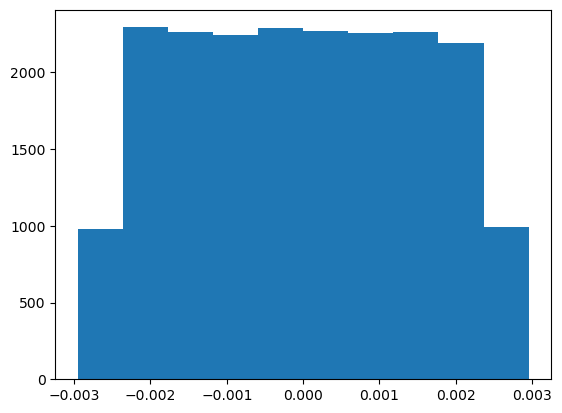

In [21]:
# almost same (within 0.003%)
d = ((st_rss - rss)/rss).values.flatten()
z=plt.hist(d)

## Regulon content

In [22]:
stable_regulons_df = pd.read_csv("../../../data.nfs/from.stephane/20220120_GambardellaL_HM_mnsc/Data/Scenic/All200c/Output/regulons_stable_80pct.csv")
st_r2g = {x:sorted(stable_regulons_df[x].dropna()) for x  in stable_regulons_df.columns}

In [23]:
len(r2g),len(st_r2g)

(371, 371)

In [24]:
set(r2g.keys()).difference(st_r2g.keys())

set()

In [25]:
# same length
Counter([len(r2g[r])-len(st_r2g[r]) for r in r2g.keys()])

Counter({0: 371})

In [26]:
# same content
Counter([len(set(r2g[r]).difference(st_r2g[r])) for r in r2g.keys()])

Counter({0: 371})